# **MODEL 3 - UNET**

# Architecture

Type info here

# Import Dependencies

In [2]:
# File Support
try: 
    import pydicom as dcm
except:
    # Use try except for Google Colab
    !pip install pydicom
from pydicom.data import get_testdata_files
import xml
import xml.etree.ElementTree as ET 

# Base
import numpy as np
import pandas as pd
import json
import random
import gc
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from PIL import Image

# SK-learn
import sklearn
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

# Files
import os
from os.path import join, split
from glob import glob

# Torch
import torch
from torch import nn
from torch.nn import Sequential, Conv2d, MaxPool2d, ReLU, ConvTranspose2d
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
from torchvision.ops import drop_block2d
from torchvision.transforms import CenterCrop
import torch.nn.functional as F
from torch.optim import AdamW
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.checkpoint import checkpoint
from torch.autograd import Variable

import tempfile
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed.fsdp import CPUOffload, wrap
import bitsandbytes as bnb

In [3]:
torch.__version__

'2.2.2+cu121'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [5]:
torch.cuda.is_available()

True

# Config

In [6]:
len(os.listdir("Numpy Dataset\\all\images"))

7547

In [7]:
class CFG:
    random_seed = 42
    gated = True
    path = "Coronary CT Data\Gated_release_final" if gated else "Coronary CT Data/deidentified_nongated"
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    train_new = True
    model_num = len(os.listdir("Models")) if train_new else len(os.listdir("Models"))-1

    batch_size = 8
    nEpochs = 100
    lr = 0.1


In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
torch.cuda.empty_cache()
gc.collect()

31

In [10]:
torch.cuda.memory_usage()

44

In [11]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

## Reproducibility

In [12]:
def set_seed(seed=CFG.random_seed):
    print(f"Seed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed()

Seed: 42


# Load Data

In [13]:
def parseXML(xmlfile): 
    # create element tree object 
    tree = ET.parse(xmlfile) 

    all_images = []

    images = tree.find("dict").find("array")
    images = images.findall("dict")

    # Images
    for image in images:
        image_data = {}
        arr = [i.text for i in image if i.tag not in ["array", "dict"]]
        
        for i in range(len(arr)//2):
            image_data[arr[2*i]] = arr[2*i+1]

        image_data['ROIs'] = []

        # ROI
        all_roi = image.find("array").findall('dict')
        for roi in all_roi:
            roi_data = {}
            arr = [i.text for i in roi if i.tag not in ["array", "dict"]]
        
            for i in range(len(arr)//2):
                roi_data[arr[2*i]] = arr[2*i+1]

            all_points = roi.findall('array')
            roi_data['point_mm'] = [i.text for i in all_points[0].findall("string")]
            roi_data['point_px'] = [i.text for i in all_points[1].findall("string")]
            
            image_data['ROIs'].append(roi_data)
        all_images.append(image_data)

    return all_images

In [14]:
def create_segments(image_array, points):
    polygon = Polygon(points, closed=True, edgecolor='r', facecolor='r')
    polygon_indices = np.array(points)
    polygon_indices[:, 0] = np.clip(polygon_indices[:, 0], 0, 511)
    polygon_indices[:, 1] = np.clip(polygon_indices[:, 1], 0, 511)
    image_array[polygon_indices[:, 1], polygon_indices[:, 0]] = 1
    polygon_path = Path(polygon_indices)
    x, y = np.meshgrid(np.arange(512), np.arange(512))
    points = np.column_stack((x.flatten(), y.flatten()))
    mask = polygon_path.contains_points(points).reshape(512, 512)
    image_array[mask] = 1

    return image_array

In [15]:
class CTDataset(Dataset):
    def __init__(self, dir):
        super().__init__()
        self.dir = dir
        self.images_path = join(dir, "images")
        self.labels_path = join(dir, "labels")
        self.images = os.listdir(self.images_path)
        self.labels = os.listdir(self.labels_path)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx): # Return tuple (x, y)
        try:
            img = np.load(join(self.images_path, self.images[idx]), allow_pickle=True)
            img = img.reshape(1, 512, 512) # Hard coded since all images are 512, 512

            label = np.load(join(self.labels_path, self.labels[idx]), allow_pickle=True)
            label = label.reshape(1, 512, 512)
        except:
            img, label = np.zeros((1,512,512), np.float32),np.zeros((1,512,512), np.float32)
        return  img,label

In [16]:
train = CTDataset("Numpy Dataset\\train")
valid = CTDataset("Numpy Dataset\\valid")
test = CTDataset("Numpy Dataset\\test")

In [17]:
trainDL = DataLoader(train, batch_size=CFG.batch_size,shuffle=True, pin_memory=True)
validDL = DataLoader(valid, batch_size=CFG.batch_size)
testDL = DataLoader(test, batch_size=1)

In [18]:
print(f"Train: {len(train)}")
print(f"Valid: {len(valid)}")
print(f"Test: {len(test)}")

Train: 5331
Valid: 1598
Test: 616


# Model

In [19]:
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat(
            (torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1
        )

In [20]:
class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=(kernel_size - 1) // 2),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # broadcasting
        return x * scale

In [21]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, attention=False):
        super().__init__()

        # print(f"IN: {in_ch}")
        # print(f"OUT: {out_ch}")
        if out_ch == 2048:
            attention = True

        self.conv1 = Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = ReLU()
        self.conv2 = Conv2d(out_ch, out_ch, 3, padding=1)
        self.conv3 = Conv2d(out_ch, out_ch, 1, padding=0)

        self.attention = SpatialGate() if attention else nn.Identity()

        # init random weights
        nn.init.xavier_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)

        nn.init.xavier_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)

        nn.init.xavier_normal_(self.conv3.weight)
        nn.init.zeros_(self.conv3.bias)
    
    def forward(self, x):
        x = self.conv1(x)
        x = drop_block2d(x, 0.1, 3, inplace=True, training=self.training)
        x = self.relu(x)

        x = self.attention(x)

        x = self.conv2(x)
        x = drop_block2d(x, 0.1, 3, inplace=True, training=self.training)
        x = self.relu(x)

        x = self.relu(self.conv3(x))
        return x

In [22]:
class AutoEncoder(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels
        self.pool = MaxPool2d((2,2))

        blocks = [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        self.encoder = nn.ModuleList(blocks)

    def forward(self, x):
        skip_out = []
        for block in self.encoder: # Goes through all blocks, passes through block and saves skip output
            x = block(x)
            skip_out.append(x)
            x = self.pool(x) # Reduces dim
        return skip_out

In [23]:
class AutoDecoder(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels[:0:-1] # Reverse of Encoder (Excluding First Unneeded in Output)
        self.pool = MaxPool2d((2,2))
        self.upconv = nn.ModuleList([
            ConvTranspose2d(self.channels[i], self.channels[i+1], 2, 2) for i in range(len(self.channels)-1)
        ])

        self.decoder = nn.ModuleList([
            Block(self.channels[i], self.channels[i+1]) for i in range(len(self.channels)-1)
        ])

    def center_crop(self, x, enc_out): # Crop encoder output
        _, _, h, w = x.shape
        enc_out = CenterCrop([h,w])(enc_out)
        return enc_out
    
    def forward(self, x, enc_out:list):
        for i in range(len(self.channels)-1):
            x = self.upconv[i](x)
            enc_ftrs = self.center_crop(x, enc_out[i]) # Crop Skip
            x = torch.cat([x, enc_ftrs], dim=1) # Concatenate Decoder and Skip
            x = self.decoder[i](x)

            # Min Max Scaling [0,1]
            x = (x-x.min())/(x.max()-x.min())
        return x


In [24]:
class UNET(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512, 1024, 2048)):
        super().__init__()

        # Encoder Path
        self.enc_path = AutoEncoder(channels)

        # Decoder Path
        self.dec_path = AutoDecoder(channels)

        self.out1 = Conv2d(channels[1], 1, 1)
        self.out2 = Conv2d(in_channels=1,out_channels=1, kernel_size=3,stride=1,padding=1)

        # init random weights
        nn.init.xavier_normal_(self.out1.weight)
        nn.init.zeros_(self.out1.bias)

        nn.init.xavier_normal_(self.out2.weight)
        nn.init.zeros_(self.out2.bias)

        self.out = Sequential(self.out1,
                              self.out2)

    
    def forward(self, x):

        skips = self.enc_path(x)
        x = self.dec_path(skips[::-1][0], skips[::-1][1:]) 
        x = self.out(x)
        x = F.sigmoid(x)

        return x

# Train

## Dice Loss

Sørensen–Dice coefficient:
[Wikipedia](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
</br>
$${\displaystyle DSC={\frac {2|X\cap Y|}{|X|+|Y|}}}

In [25]:
class diceCoef(nn.Module):
    def init(self):
        super(diceCoef, self).init()

    def forward(self, inputs, targets, smooth=1):        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [26]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [27]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [28]:
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, ALPHA = 0.5, BETA = 0.5):
        super(TverskyLoss, self).__init__()
        self.alpha = ALPHA
        self.beta = BETA

    def forward(self, inputs, targets, smooth=1):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + self.alpha*FP + self.beta*FN + smooth)  
        
        return 1 - Tversky

In [29]:
criterion_dice_bce = DiceBCELoss()

In [30]:
criterion_dice = diceCoef()

In [31]:
criterion_iou = IoULoss()

In [32]:
criterion_bce = torch.nn.BCEWithLogitsLoss()

In [33]:
criterion_tversk = TverskyLoss()

## Training Loop

In [34]:
trainDL = DataLoader(train, batch_size=16, shuffle=True)
validDL = DataLoader(valid, batch_size=16, shuffle=False)

In [35]:
def train_epoch(model,  criterion, optim, scheduler):      
    train_loss = 0
    bce_loss = 0
    iou_loss = 0
    dice_loss = 0
    for x,y in tqdm(trainDL):
        x, y = x.to(CFG.device), y.to(CFG.device)
        optim.zero_grad()
        with torch.cuda.amp.autocast(dtype=torch.float16):
            pred = checkpoint(model, x).detach()
            pred = pred*x
            loss = criterion(pred, y)
            loss = Variable(loss, requires_grad=True)
            
        loss.backward()
        optim.step()
        train_loss += loss
        del x,y,pred,loss
    
    
    # eval
    with torch.no_grad():
        for x,y in validDL:
            x, y = x.to(CFG.device), y.to(CFG.device)
            pred = model(x).detach()
            pred = pred*x
            loss_bce = criterion_bce(pred, y)
            loss_dice = criterion_dice(pred,y)
            loss_iou = criterion_iou(pred, y)
            bce_loss += loss_bce
            iou_loss += loss_iou
            dice_loss += loss_dice
    
    scheduler.step(bce_loss)
        
    avg_train_loss = train_loss/len(trainDL)
    avg_bce_loss = bce_loss/len(validDL)
    avg_iou_loss = iou_loss/len(validDL)
    avg_dice_loss = dice_loss/len(validDL)

    
    print(f"Train Loss: {avg_train_loss}")
    print(f"Validation BCE Loss: {avg_bce_loss}")
    print(f"Validation Dice Loss: {avg_dice_loss}")
    print(f"Validation IOU Loss: {avg_iou_loss}")
    return avg_train_loss, avg_bce_loss

In [36]:
def run_model(criterion, model = None, init_lr = 0.1, name = "model", nEpochs = CFG.nEpochs):
    if not model:
        model = UNET().to(CFG.device)
    model.train()

    optim = AdamW(model.parameters(), lr=init_lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, min_lr=0.0001, verbose=True)

    train_hist = []
    val_hist = []

    for e in range(nEpochs):
        print(f"\n\n[INFO] Epoch {e+1}/{nEpochs}")
        print(scheduler.optimizer.param_groups[0]['lr'])
        train_loss, val_loss = train_epoch(model, criterion, optim, scheduler)
        train_hist.append(float(train_loss.detach().cpu()))
        val_hist.append(float(val_loss.detach().cpu()))

    if not os.path.exists(f"Models/{name}"):
        os.mkdir(f"Models/{name}")
    torch.save(model.state_dict(), f"Models/{name}/model.pt")

    history = pd.DataFrame({"train":train_hist, 
                         'validation':val_hist}, index = range(1,len(train_hist)+1))
    
    history.to_csv(f"Models/{name}/logs.csv")

In [37]:
for i in range(100):
    a = 0.82
    b = 0.2

    criterion = TverskyLoss(ALPHA = a, BETA = b)
    
    run_model(criterion, name=f"SAUNET-{i}", nEpochs=2)

KeyboardInterrupt: 

In [38]:
losses = {}
for i in glob("Models/**"):
    if os.path.exists(f"{i}\logs.csv"):
        try:
            file_loss = min(pd.read_csv(f"{i}\logs.csv")["validation"])
            losses[split(i)[-1]] = file_loss
        except:
            continue

In [39]:
losses_train = {}
for i in glob("Models/**"):
    if os.path.exists(f"{i}\logs.csv"):
        try:
            file_loss = min(pd.read_csv(f"{i}\logs.csv")["train"])
            losses_train[split(i)[-1]] = file_loss
        except:
            continue

In [40]:
retrain = sorted([losses[i] for i in losses.keys() if "SAUNET-" in i])[0:1]
retrain

[0.7480215430259705]

In [41]:
retrain_train = sorted([losses_train[i] for i in losses_train.keys() if "SAUNET-" in i])[0:1]
retrain_train

[0.7483721375465393]

In [42]:
retrain_models = []

for i in losses:
    if losses[i] in retrain or losses[i] in retrain_train:
        if "SAUNET" in i:
            print(i)
            best = f"Models/{i}/model.pt"
            retrain_models.append(best)
for i in losses_train:
    if losses_train[i] in retrain or losses_train[i] in retrain_train:
        if "SAUNET" in i:
            print(i)
            best = f"Models/{i}/model.pt"
            retrain_models.append(best)

Fine Tuned SAUNET-29
Fine Tuned BCE SAUNET-29


In [43]:
all_models = {}
TRAIN = False
if TRAIN:
    for i in retrain_models:
        try:
            model = UNET().to(CFG.device)
            model.load_state_dict(torch.load(i))
            
            criterion = TverskyLoss(ALPHA = 0.82, BETA = 0.2)
            run_model(model = model, criterion=criterion, name=f"Fine Tuned {i.split('/')[1]}", nEpochs=100)
            all_models[i] = model.state_dict()
        except:
            pass



[INFO] Epoch 1/100
0.1


 11%|█         | 37/334 [00:17<02:19,  2.13it/s]


In [70]:
all_models = {}
TRAIN = True
if TRAIN:
    for i in retrain_models:
        try:
            model = UNET().to(CFG.device)
            model.load_state_dict(torch.load(i))
            
            run_model(model = model, criterion=criterion_bce, name=f"Fine Tuned BCE {i.split('/')[1]}", nEpochs=25)
            all_models[i] = model.state_dict()
        except:
            pass



[INFO] Epoch 1/25
0.1


100%|██████████| 334/334 [02:13<00:00,  2.50it/s]


Train Loss: 0.7484678626060486
Validation BCE Loss: 0.7484933137893677
Validation Dice Loss: 0.9999451041221619
Validation IOU Loss: 0.9999715685844421


[INFO] Epoch 2/25
0.1


100%|██████████| 334/334 [02:14<00:00,  2.48it/s]


Train Loss: 0.7485743761062622
Validation BCE Loss: 0.7485807538032532
Validation Dice Loss: 0.9999462962150574
Validation IOU Loss: 0.9999722242355347


[INFO] Epoch 3/25
0.1


100%|██████████| 334/334 [02:12<00:00,  2.51it/s]


Train Loss: 0.7484216094017029
Validation BCE Loss: 0.7483832240104675
Validation Dice Loss: 0.999946117401123
Validation IOU Loss: 0.9999722242355347


[INFO] Epoch 4/25
0.1


100%|██████████| 334/334 [02:13<00:00,  2.51it/s]


Train Loss: 0.748582124710083
Validation BCE Loss: 0.7484917044639587
Validation Dice Loss: 0.9999447464942932
Validation IOU Loss: 0.9999713897705078


[INFO] Epoch 5/25
0.1


100%|██████████| 334/334 [02:13<00:00,  2.50it/s]


Train Loss: 0.7486746311187744
Validation BCE Loss: 0.7483175992965698
Validation Dice Loss: 0.9999454021453857
Validation IOU Loss: 0.9999718070030212


[INFO] Epoch 6/25
0.1


100%|██████████| 334/334 [02:13<00:00,  2.51it/s]


Train Loss: 0.7485021352767944
Validation BCE Loss: 0.7485805153846741
Validation Dice Loss: 0.999945878982544
Validation IOU Loss: 0.9999719858169556


[INFO] Epoch 7/25
0.1


100%|██████████| 334/334 [02:13<00:00,  2.50it/s]


Train Loss: 0.7488110661506653
Validation BCE Loss: 0.7483373284339905
Validation Dice Loss: 0.9999450445175171
Validation IOU Loss: 0.9999714493751526


[INFO] Epoch 8/25
0.1


100%|██████████| 334/334 [02:22<00:00,  2.34it/s]


Train Loss: 0.7487568259239197
Validation BCE Loss: 0.7486029863357544
Validation Dice Loss: 0.9999452829360962
Validation IOU Loss: 0.9999715685844421


[INFO] Epoch 9/25
0.1


100%|██████████| 334/334 [02:12<00:00,  2.52it/s]


Train Loss: 0.7485252022743225
Validation BCE Loss: 0.7483686804771423
Validation Dice Loss: 0.9999460577964783
Validation IOU Loss: 0.9999719858169556


[INFO] Epoch 10/25
0.1


100%|██████████| 334/334 [02:14<00:00,  2.48it/s]


Train Loss: 0.7488759160041809
Validation BCE Loss: 0.7486212849617004
Validation Dice Loss: 0.9999456405639648
Validation IOU Loss: 0.9999719262123108


[INFO] Epoch 11/25
0.1


100%|██████████| 334/334 [02:14<00:00,  2.49it/s]


Train Loss: 0.7485671043395996
Validation BCE Loss: 0.7483571171760559
Validation Dice Loss: 0.9999452233314514
Validation IOU Loss: 0.9999716877937317


[INFO] Epoch 12/25
0.1


100%|██████████| 334/334 [02:11<00:00,  2.54it/s]


Train Loss: 0.7486761212348938
Validation BCE Loss: 0.7484854459762573
Validation Dice Loss: 0.9999451041221619
Validation IOU Loss: 0.9999716877937317


[INFO] Epoch 13/25
0.1


100%|██████████| 334/334 [02:09<00:00,  2.57it/s]


Train Loss: 0.748803973197937
Validation BCE Loss: 0.7481902837753296
Validation Dice Loss: 0.9999451041221619
Validation IOU Loss: 0.9999715089797974


[INFO] Epoch 14/25
0.1


100%|██████████| 334/334 [02:13<00:00,  2.50it/s]


Train Loss: 0.7485643625259399
Validation BCE Loss: 0.7485235333442688
Validation Dice Loss: 0.9999457597732544
Validation IOU Loss: 0.9999718070030212


[INFO] Epoch 15/25
0.1


100%|██████████| 334/334 [02:34<00:00,  2.16it/s]


Train Loss: 0.7486939430236816
Validation BCE Loss: 0.7485003471374512
Validation Dice Loss: 0.9999456405639648
Validation IOU Loss: 0.9999719262123108


[INFO] Epoch 16/25
0.1


100%|██████████| 334/334 [02:10<00:00,  2.56it/s]


Train Loss: 0.7486371397972107
Validation BCE Loss: 0.7482673525810242
Validation Dice Loss: 0.9999455213546753
Validation IOU Loss: 0.9999719262123108


[INFO] Epoch 17/25
0.1


100%|██████████| 334/334 [02:10<00:00,  2.56it/s]


Train Loss: 0.7487096786499023
Validation BCE Loss: 0.7483122944831848
Validation Dice Loss: 0.9999458193778992
Validation IOU Loss: 0.9999719262123108


[INFO] Epoch 18/25
0.1


100%|██████████| 334/334 [02:20<00:00,  2.37it/s]


Train Loss: 0.7486308217048645
Validation BCE Loss: 0.7486163973808289
Validation Dice Loss: 0.9999454021453857
Validation IOU Loss: 0.9999715685844421


[INFO] Epoch 19/25
0.1


100%|██████████| 334/334 [02:18<00:00,  2.40it/s]


Train Loss: 0.7487531304359436
Validation BCE Loss: 0.748584508895874
Validation Dice Loss: 0.9999451041221619
Validation IOU Loss: 0.9999715089797974


[INFO] Epoch 20/25
0.1


100%|██████████| 334/334 [03:28<00:00,  1.60it/s]


Train Loss: 0.74873286485672
Validation BCE Loss: 0.748724102973938
Validation Dice Loss: 0.9999458193778992
Validation IOU Loss: 0.9999718070030212


[INFO] Epoch 21/25
0.1


100%|██████████| 334/334 [02:10<00:00,  2.56it/s]


Train Loss: 0.7486200928688049
Validation BCE Loss: 0.7485734224319458
Validation Dice Loss: 0.9999446868896484
Validation IOU Loss: 0.9999712705612183


[INFO] Epoch 22/25
0.1


100%|██████████| 334/334 [03:27<00:00,  1.61it/s]


Train Loss: 0.7487427592277527
Validation BCE Loss: 0.7485630512237549
Validation Dice Loss: 0.9999458193778992
Validation IOU Loss: 0.9999718070030212


[INFO] Epoch 23/25
0.1


100%|██████████| 334/334 [02:23<00:00,  2.33it/s]


Train Loss: 0.748481273651123
Validation BCE Loss: 0.7484422326087952
Validation Dice Loss: 0.9999451041221619
Validation IOU Loss: 0.9999714493751526


[INFO] Epoch 24/25
0.1


100%|██████████| 334/334 [02:26<00:00,  2.28it/s]


Train Loss: 0.7487597465515137
Validation BCE Loss: 0.7484211325645447
Validation Dice Loss: 0.9999448657035828
Validation IOU Loss: 0.9999714493751526


[INFO] Epoch 25/25
0.05


100%|██████████| 334/334 [02:12<00:00,  2.52it/s]


Train Loss: 0.7485966682434082
Validation BCE Loss: 0.7483866810798645
Validation Dice Loss: 0.9999448657035828
Validation IOU Loss: 0.9999713897705078


[INFO] Epoch 1/25
0.1


100%|██████████| 334/334 [02:10<00:00,  2.56it/s]


Train Loss: 0.7486185431480408
Validation BCE Loss: 0.7483347058296204
Validation Dice Loss: 0.9999452829360962
Validation IOU Loss: 0.9999716877937317


[INFO] Epoch 2/25
0.1


100%|██████████| 334/334 [02:11<00:00,  2.53it/s]


Train Loss: 0.7484707832336426
Validation BCE Loss: 0.7483949661254883
Validation Dice Loss: 0.9999454021453857
Validation IOU Loss: 0.9999717473983765


[INFO] Epoch 3/25
0.1


100%|██████████| 334/334 [02:10<00:00,  2.56it/s]


Train Loss: 0.748746395111084
Validation BCE Loss: 0.74819016456604
Validation Dice Loss: 0.9999448657035828
Validation IOU Loss: 0.9999715089797974


[INFO] Epoch 4/25
0.1


100%|██████████| 334/334 [02:10<00:00,  2.56it/s]


Train Loss: 0.7486971616744995
Validation BCE Loss: 0.7481976747512817
Validation Dice Loss: 0.9999454021453857
Validation IOU Loss: 0.9999716877937317


[INFO] Epoch 5/25
0.1


100%|██████████| 334/334 [02:10<00:00,  2.56it/s]


Train Loss: 0.7487196326255798
Validation BCE Loss: 0.7482188940048218
Validation Dice Loss: 0.9999455213546753
Validation IOU Loss: 0.9999718070030212


[INFO] Epoch 6/25
0.1


100%|██████████| 334/334 [02:10<00:00,  2.56it/s]


Train Loss: 0.7486999034881592
Validation BCE Loss: 0.748310923576355
Validation Dice Loss: 0.9999457597732544
Validation IOU Loss: 0.9999718070030212


[INFO] Epoch 7/25
0.1


100%|██████████| 334/334 [02:08<00:00,  2.61it/s]


Train Loss: 0.7487574815750122
Validation BCE Loss: 0.748614490032196
Validation Dice Loss: 0.9999457597732544
Validation IOU Loss: 0.9999719262123108


[INFO] Epoch 8/25
0.1


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7486483454704285
Validation BCE Loss: 0.7486460208892822
Validation Dice Loss: 0.9999459385871887
Validation IOU Loss: 0.9999720454216003


[INFO] Epoch 9/25
0.1


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7484240531921387
Validation BCE Loss: 0.7484378814697266
Validation Dice Loss: 0.9999452829360962
Validation IOU Loss: 0.9999714493751526


[INFO] Epoch 10/25
0.1


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7487423419952393
Validation BCE Loss: 0.7486169338226318
Validation Dice Loss: 0.9999452829360962
Validation IOU Loss: 0.9999715685844421


[INFO] Epoch 11/25
0.1


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7485805749893188
Validation BCE Loss: 0.7482768893241882
Validation Dice Loss: 0.9999456405639648
Validation IOU Loss: 0.9999719262123108


[INFO] Epoch 12/25
0.1


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7484912872314453
Validation BCE Loss: 0.7485240697860718
Validation Dice Loss: 0.9999454021453857
Validation IOU Loss: 0.9999717473983765


[INFO] Epoch 13/25
0.1


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7486844062805176
Validation BCE Loss: 0.748389482498169
Validation Dice Loss: 0.999945878982544
Validation IOU Loss: 0.9999718070030212


[INFO] Epoch 14/25
0.1


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7487227916717529
Validation BCE Loss: 0.7484798431396484
Validation Dice Loss: 0.9999451041221619
Validation IOU Loss: 0.9999715685844421


[INFO] Epoch 15/25
0.05


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7487604022026062
Validation BCE Loss: 0.748382031917572
Validation Dice Loss: 0.9999455213546753
Validation IOU Loss: 0.9999716877937317


[INFO] Epoch 16/25
0.05


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7486799359321594
Validation BCE Loss: 0.7485529184341431
Validation Dice Loss: 0.9999454021453857
Validation IOU Loss: 0.9999716877937317


[INFO] Epoch 17/25
0.05


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7486554980278015
Validation BCE Loss: 0.7486076354980469
Validation Dice Loss: 0.9999455809593201
Validation IOU Loss: 0.9999718070030212


[INFO] Epoch 18/25
0.05


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7486851811408997
Validation BCE Loss: 0.7484273910522461
Validation Dice Loss: 0.9999448657035828
Validation IOU Loss: 0.9999715089797974


[INFO] Epoch 19/25
0.05


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7486327290534973
Validation BCE Loss: 0.7482575178146362
Validation Dice Loss: 0.9999455809593201
Validation IOU Loss: 0.9999718070030212


[INFO] Epoch 20/25
0.05


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7486208081245422
Validation BCE Loss: 0.7486488223075867
Validation Dice Loss: 0.999945342540741
Validation IOU Loss: 0.9999717473983765


[INFO] Epoch 21/25
0.05


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7488128542900085
Validation BCE Loss: 0.7483847141265869
Validation Dice Loss: 0.999946117401123
Validation IOU Loss: 0.9999722242355347


[INFO] Epoch 22/25
0.05


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7485780119895935
Validation BCE Loss: 0.748602032661438
Validation Dice Loss: 0.9999455809593201
Validation IOU Loss: 0.9999718070030212


[INFO] Epoch 23/25
0.05


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7485502362251282
Validation BCE Loss: 0.748306930065155
Validation Dice Loss: 0.999944806098938
Validation IOU Loss: 0.9999713897705078


[INFO] Epoch 24/25
0.05


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.7484788298606873
Validation BCE Loss: 0.7485421299934387
Validation Dice Loss: 0.9999458193778992
Validation IOU Loss: 0.9999720454216003


[INFO] Epoch 25/25
0.05


100%|██████████| 334/334 [02:06<00:00,  2.64it/s]


Train Loss: 0.748783528804779
Validation BCE Loss: 0.7484902143478394
Validation Dice Loss: 0.9999455213546753
Validation IOU Loss: 0.9999718070030212


In [44]:
final_losses = {}
for i in glob("Models/**"):
    if os.path.exists(f"{i}\logs.csv"):
        try:
            file_loss = min(pd.read_csv(f"{i}\logs.csv")["validation"])
            final_losses[split(i)[-1]] = file_loss
        except:
            continue

In [45]:
lowest_losses = sorted([final_losses[i] for i in final_losses.keys() if "Fine Tuned SAUNET-" in i])
lowest_losses

[0.7480215430259705, 0.7947056889533997]

In [74]:
lowest_losses2 = sorted([final_losses[i] for i in final_losses.keys() if "Fine Tuned BCE SAUNET" in i])
lowest_losses2

[0.7480818629264832]

In [75]:
lowest_losses.extend(lowest_losses2)

In [77]:
final_models = []
for i in final_losses:
    if final_losses[i] in lowest_losses and "Fine Tuned SAUNET-" in i:
        m = f"Models/{i}/model.pt"
        final_models.append(m)
    if final_losses[i] in lowest_losses and "Fine Tuned BCE SAUNET-" in i:
        m = f"Models/{i}/model.pt"
        final_models.append(m)

final_models

['Models/Fine Tuned BCE SAUNET-29/model.pt',
 'Models/Fine Tuned SAUNET-29/model.pt',
 'Models/Fine Tuned SAUNET-85/model.pt']

# Inference

In [78]:
def run_inference(img_num = None, th=97, upper=98, model=None):
    if not img_num:
        img_num = random.randint(1, len(test))

    print(f"Image Number: {img_num}")

    img = test[img_num][0]
    label = test[img_num][1]

    inference_img = torch.Tensor(img).to(CFG.device).reshape(1,1,512,512)
    model.eval()
    inference = model(inference_img)
    inf = inference.squeeze().detach().cpu().numpy()
    inf2 = (inf-inf.min())/inf.max()
    inf2 = inf2*img.squeeze()
    th = np.percentile(inf2.flatten(), th)

    fig,ax = plt.subplots(1,4,figsize=(15,15))

    ax[0].imshow(img.transpose(1,2,0), cmap='gray')
    ax[0].axis(False)
    ax[0].set_title("Image", fontsize=10)

    ax[1].imshow(inf2>th, cmap='gray')
    ax[1].axis(False)
    ax[1].set_title("Prediction", fontsize=10)

    ax[2].imshow(label.squeeze(), cmap='gray')
    ax[2].axis(False)
    ax[2].set_title("Label", fontsize=10)

    pred1 = (inf2>th)
    pred2 = (inf2<upper)
    pred = pred1*pred2

    overlay = (img*0.1).squeeze()
    overlay = np.stack([overlay, overlay, overlay]).transpose(1,2,0)
    overlay[:,:,1] = overlay[:,:,1] + (label.squeeze() * img.squeeze()).squeeze()*0.2  # Red
    overlay[:,:,0] = overlay[:,:,0] + (pred.squeeze() * label.squeeze()).squeeze() # Green
    ax[3].imshow(overlay)
    ax[3].axis(False)
    ax[3].set_title("Accuracy", fontsize=10)
    plt.show()

In [79]:
def infer_all_models(img_num=None, th=97, upper_th = 98):
    if img_num is None:
        valid_img = False
        while not valid_img:
            img_num = random.randint(1, len(test))
            if test[img_num][1].sum() < 1.0:
                pass
            else:
                valid_img = True
    else:
        pass

    for i in final_models:
        print(i)
        model = UNET().to(CFG.device)
        model.load_state_dict(torch.load(i))

        run_inference(img_num, th, upper_th, model=model)

Models/Fine Tuned BCE SAUNET-29/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 460


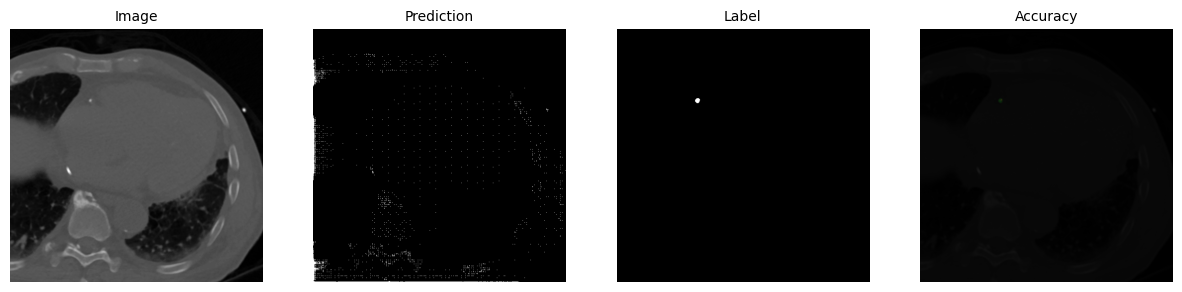

Models/Fine Tuned SAUNET-29/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 460


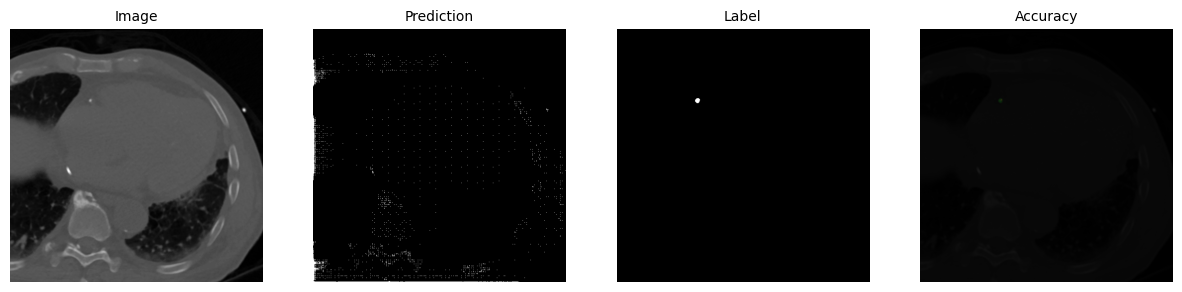

Models/Fine Tuned SAUNET-85/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 460


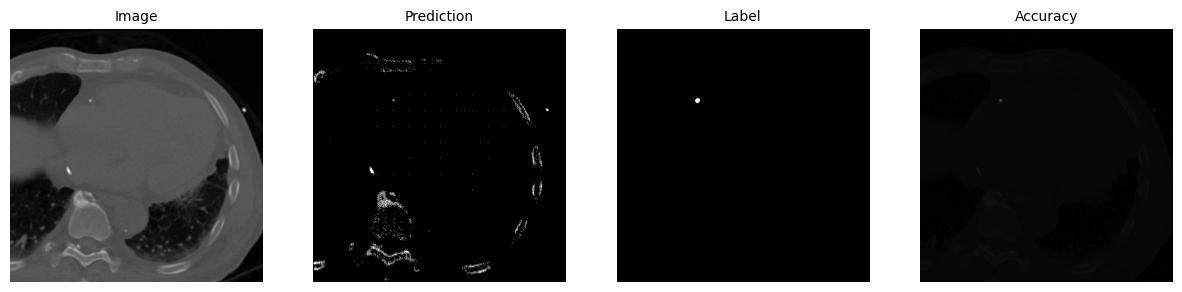

Models/Fine Tuned BCE SAUNET-29/model.pt
Image Number: 347


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


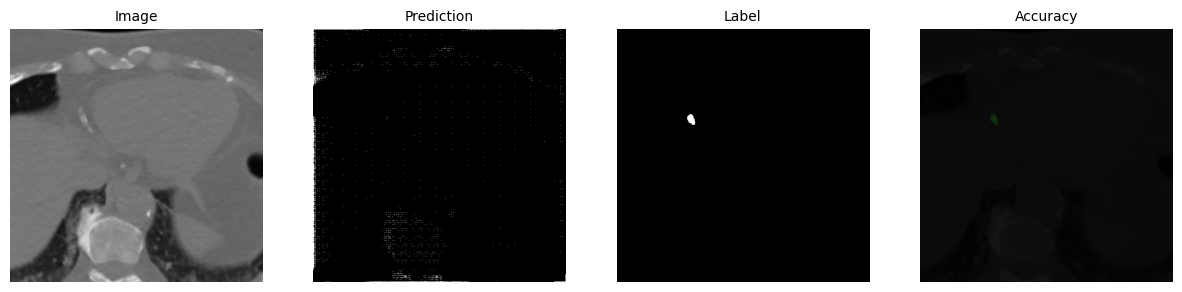

Models/Fine Tuned SAUNET-29/model.pt
Image Number: 347


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


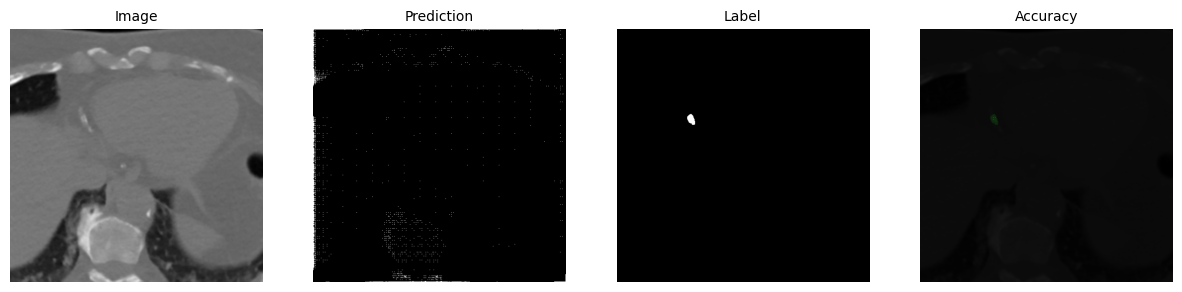

Models/Fine Tuned SAUNET-85/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 347


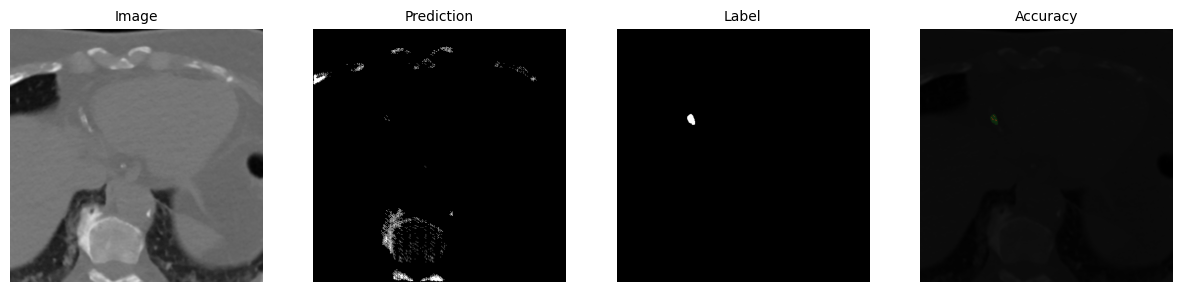

Models/Fine Tuned BCE SAUNET-29/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 463


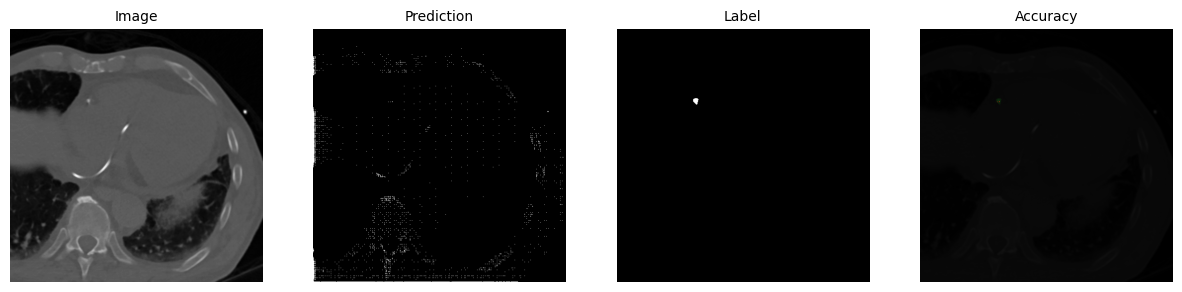

Models/Fine Tuned SAUNET-29/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 463


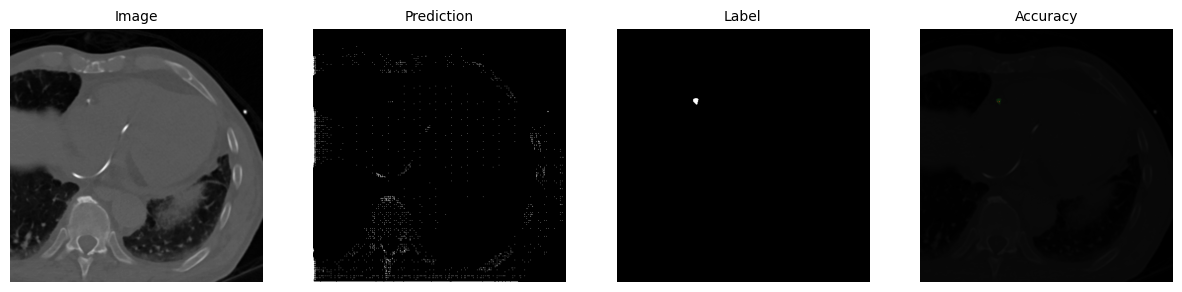

Models/Fine Tuned SAUNET-85/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 463


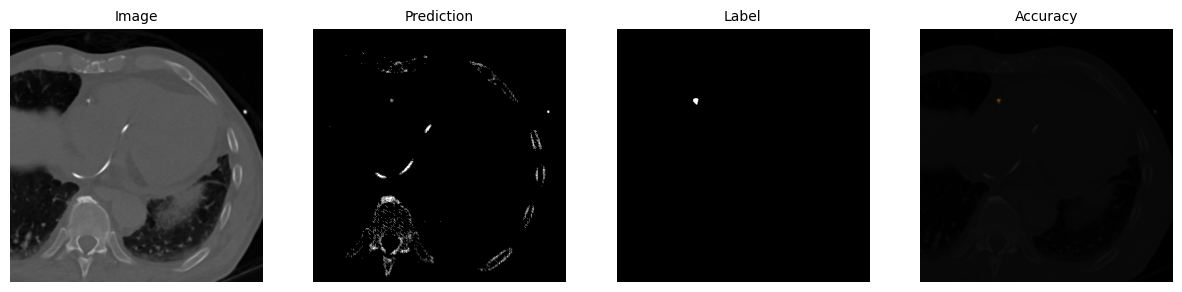

Models/Fine Tuned BCE SAUNET-29/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 498


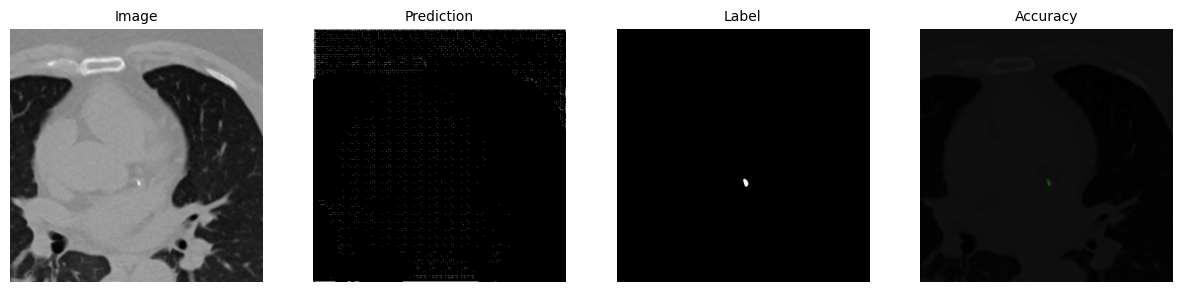

Models/Fine Tuned SAUNET-29/model.pt
Image Number: 498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


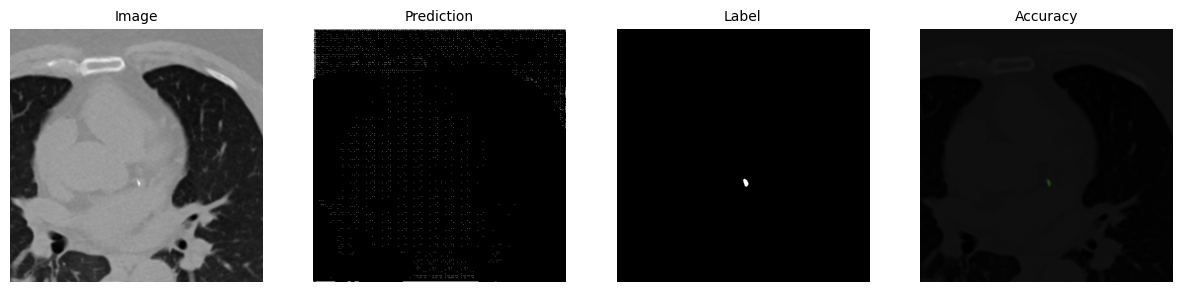

Models/Fine Tuned SAUNET-85/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 498


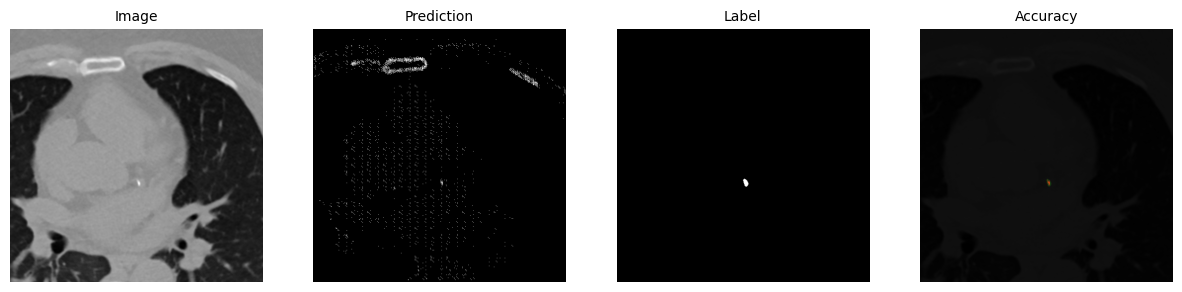

Models/Fine Tuned BCE SAUNET-29/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 348


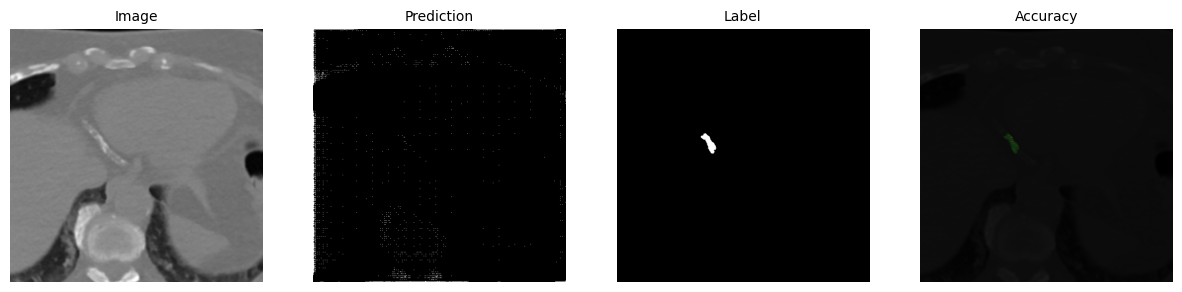

Models/Fine Tuned SAUNET-29/model.pt
Image Number: 348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


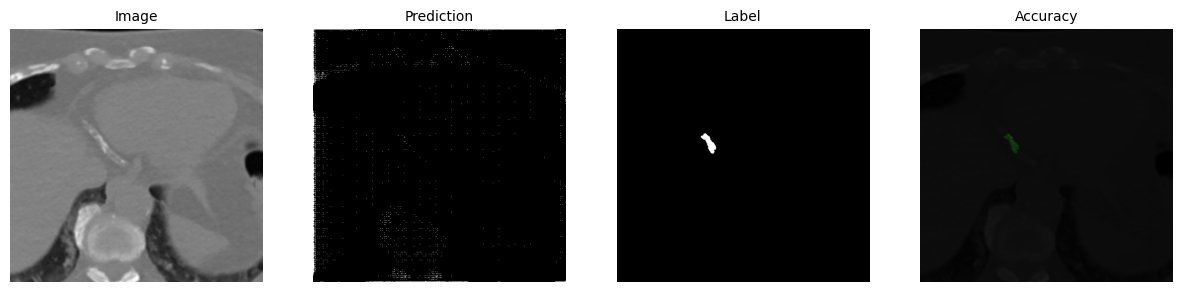

Models/Fine Tuned SAUNET-85/model.pt
Image Number: 348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


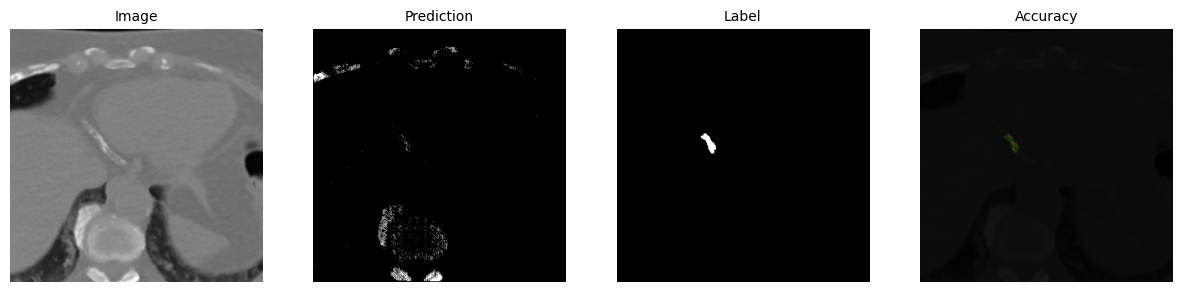

Models/Fine Tuned BCE SAUNET-29/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 550


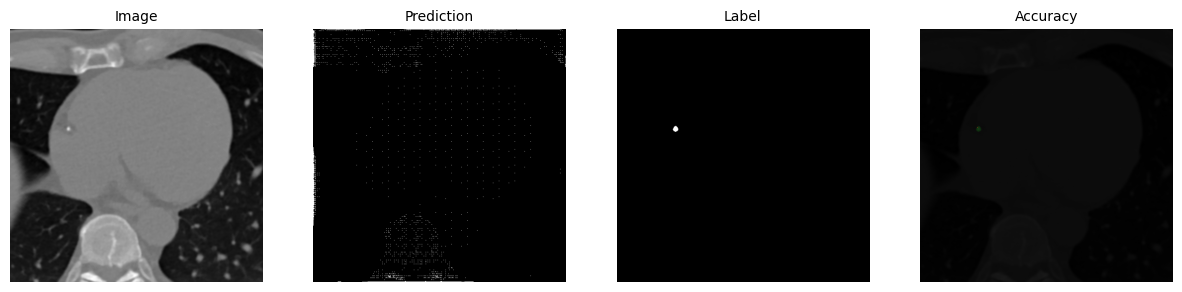

Models/Fine Tuned SAUNET-29/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 550


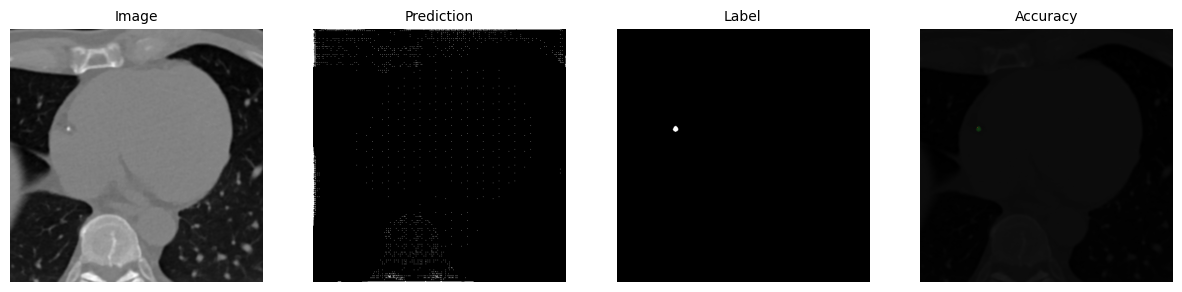

Models/Fine Tuned SAUNET-85/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 550


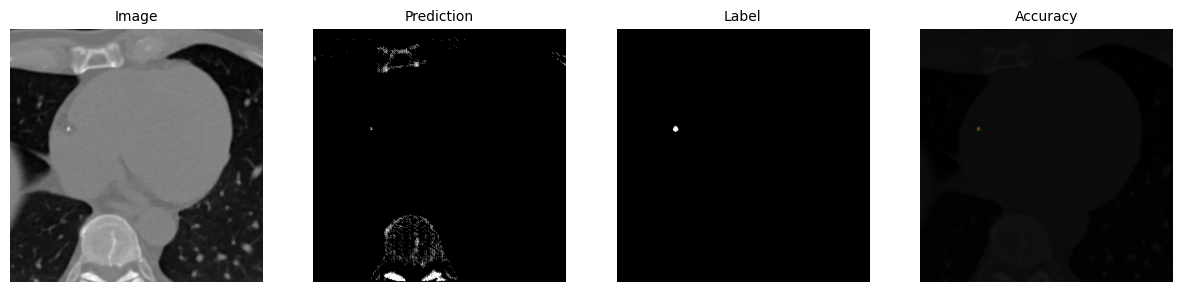

Models/Fine Tuned BCE SAUNET-29/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 554


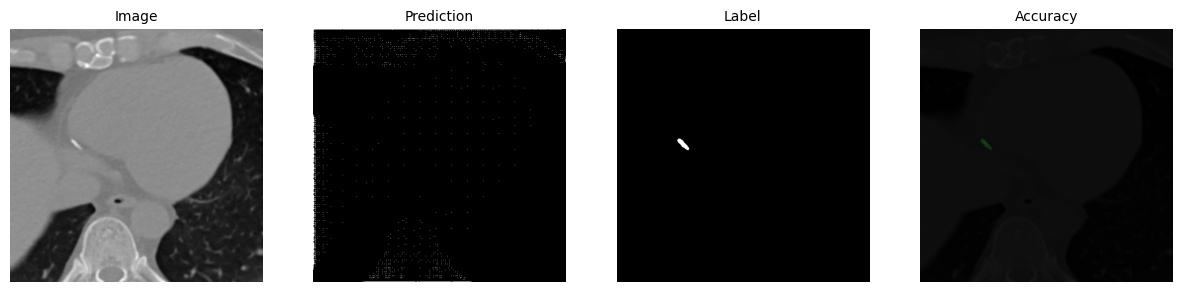

Models/Fine Tuned SAUNET-29/model.pt
Image Number: 554


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


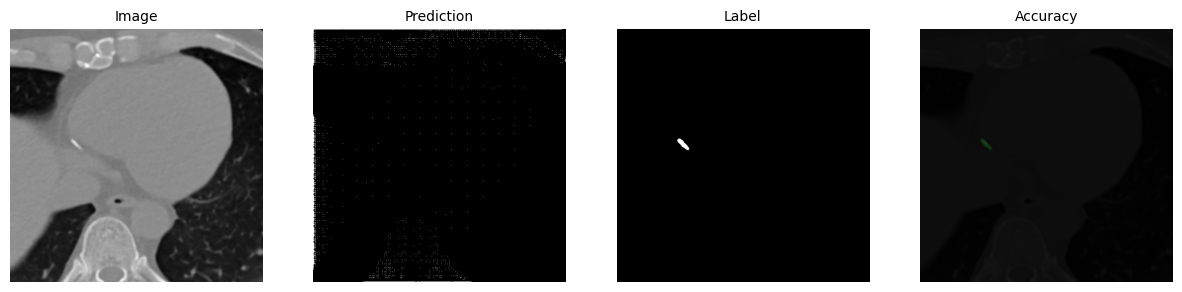

Models/Fine Tuned SAUNET-85/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 554


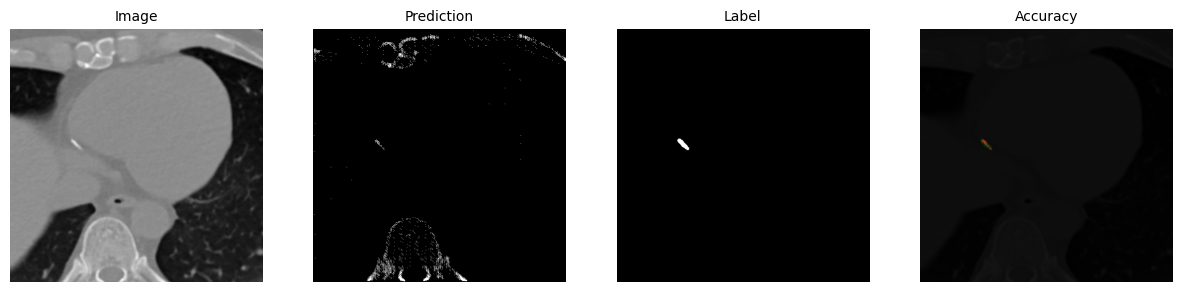

CPU times: total: 9.11 s
Wall time: 31.7 s


In [80]:
%%time
for i in [460, 347, 463, 498, 348, 550, 554]:
    infer_all_models(i, th=99)

Models/Fine Tuned BCE SAUNET-29/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 536


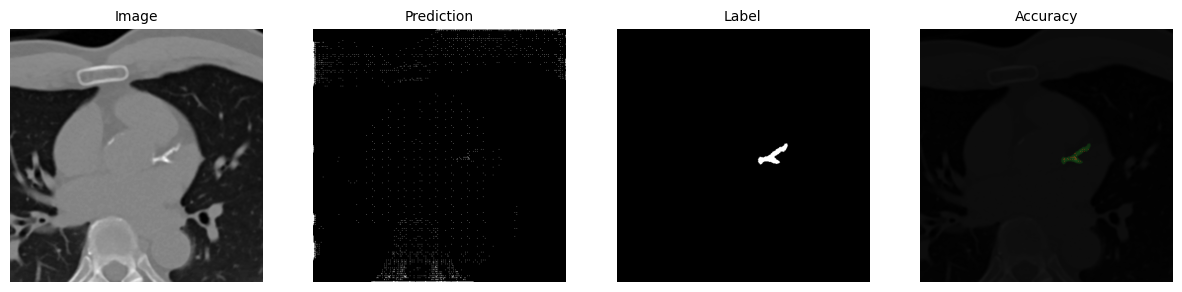

Models/Fine Tuned SAUNET-29/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 536


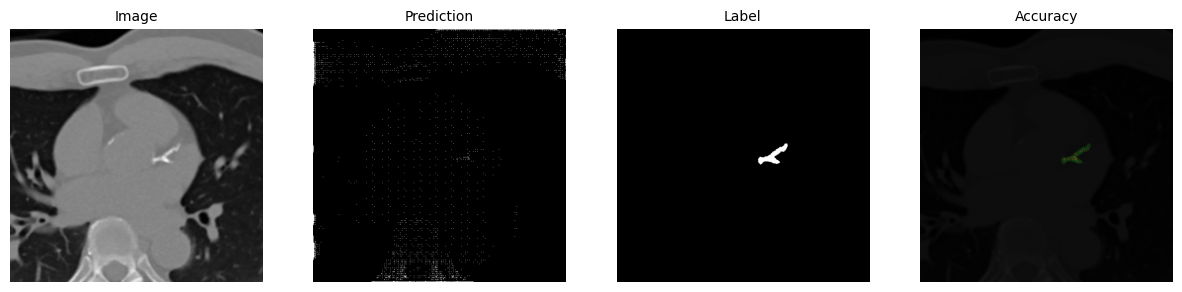

Models/Fine Tuned SAUNET-85/model.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 536


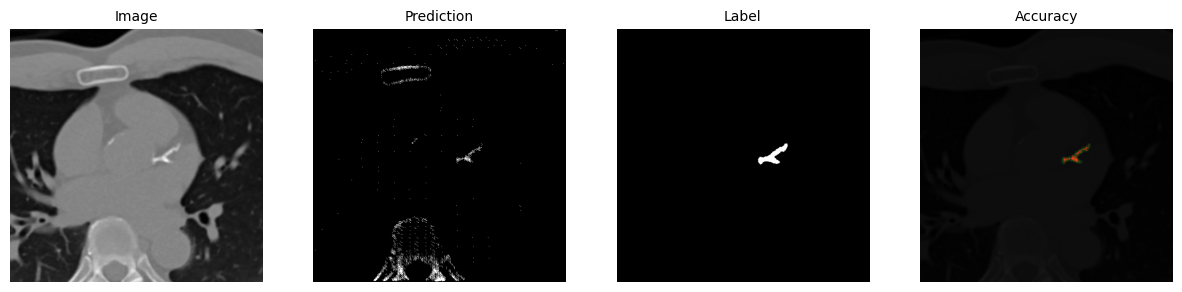

In [82]:
infer_all_models(536, 99)

In [81]:
for i in final_models:
    print(i)
    bce_loss = 0
    iou_loss = 0
    dice_loss = 0
    model = UNET().to(CFG.device)
    model.load_state_dict(torch.load(i))
    with torch.no_grad():
        for x,y in testDL:
            x, y = x.to(CFG.device), y.to(CFG.device)
            pred = model(x)
            pred = pred*x
            loss_bce = criterion_bce(pred, y)
            loss_dice = criterion_dice(pred,y)
            loss_iou = criterion_iou(pred, y)
            bce_loss += loss_bce
            iou_loss += loss_iou
            dice_loss += loss_dice
    BCE_LOSS = bce_loss/len(testDL)
    DICE_LOSS = dice_loss/len(testDL)
    IOU_LOSS = iou_loss/len(testDL)
    print(f"BCE: {BCE_LOSS}")
    print(f"DICE: {DICE_LOSS}")
    print(f"IOU: {IOU_LOSS}")

Models/Fine Tuned BCE SAUNET-29/model.pt
BCE: 0.7469466328620911
DICE: 0.9996713399887085
IOU: 0.9998149275779724
Models/Fine Tuned SAUNET-29/model.pt
BCE: 0.7470585107803345
DICE: 0.9996694326400757
IOU: 0.9998140931129456
Models/Fine Tuned SAUNET-85/model.pt
BCE: 0.799403727054596
DICE: 0.9996644854545593
IOU: 0.999821662902832


# Time

In [54]:
inf_images = []
for i in range(100):
    img = test[i][0]
    img = torch.Tensor(img).to(CFG.device).reshape(1,1,512,512)
    inf_images.append(img)


In [65]:
model.eval()

UNET(
  (enc_path): AutoEncoder(
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (encoder): ModuleList(
      (0): Block(
        (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (attention): Identity()
      )
      (1): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (attention): Identity()
      )
      (2): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [69]:
%%time
for i in inf_images:
    model(i)

CPU times: total: 46.9 ms
Wall time: 3.14 s


In [56]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
f"{get_n_params(model)} Trainable Parameters"

'131420368 Trainable Parameters'